In [1]:
import dataloader2
import numpy as np
import os
len(dataloader2.good_sids)

37

In [2]:
np.random.seed(42)
train_sids = np.random.choice(dataloader2.good_sids, 30)
test_sids = [i for i in dataloader2.good_sids if i not in train_sids]

In [3]:
test_sids

['08db4255286f',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '3452b878e596',
 '349c5562ee2c',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '7822ee8fe3ec',
 'a9a2f7fac455',
 'c6788e579967',
 'c68260cc9e8f',
 'd150801f3145',
 'd25e479ecbb7']

In [4]:
from models import model1min

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 14, 32)         800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 4, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 2112 (8.25 KB)
Trainable params: 2112 (8.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [5]:
import pandas as pd
events = pd.read_csv('data/train_events.csv')

In [6]:
sid_events = events.loc[[i in test_sids for i in events['series_id']]]

In [7]:
events.shape, sid_events.shape

((14508, 5), (738, 5))

In [8]:
xAndIndexes = [model1min.getXandIndex(f"data/sids/{sid}.parquet") for sid in test_sids]
preds = [model1min.model(x) for x,_ in xAndIndexes]

In [16]:
import importlib
import postprocess
importlib.reload(postprocess)

<module 'postprocess' from 'd:\\Projects\\ChildMindSleep\\postprocess.py'>

In [64]:
from postprocess import smooth, tabulate, drop_intervals
from tqdm.notebook import tqdm

n = 48
smooths = [ smooth(y[:, 1], n*12) for y in preds]
smooths = [ smooth(i, n*12) for i in smooths]
tables = []
for sm, (_,idx), sid in tqdm(zip(smooths, xAndIndexes, test_sids[:1]), total=16):
    df = dataloader2.load_sid(f"data/sids/{sid}.parquet")
    table = tabulate(sm, idx, df)
    # table = drop_intervals(table, 60*12)
    tables.append(table)
    tables[-1]['series_id'] = sid


  0%|          | 0/16 [00:00<?, ?it/s]

In [65]:
preds_df = pd.concat(tables)
preds_df.shape

(60, 5)

In [66]:
preds_df.head()

,event,step,timestamp,score,series_id
0,onset,9249,2018-11-06 02:50:45+00:00,1,08db4255286f
1,wakeup,11347,2018-11-06 05:45:35+00:00,1,08db4255286f
2,onset,11947,2018-11-06 06:35:35+00:00,1,08db4255286f
3,wakeup,14331,2018-11-06 09:54:15+00:00,1,08db4255286f
4,onset,26520,2018-11-07 02:50:00+00:00,1,08db4255286f


In [91]:
preds_df.dtypes

event                     object
step                      uint32
timestamp    datetime64[ns, UTC]
score                      int64
series_id                 object
dtype: object

In [67]:
import evaluations
score = evaluations.scoreIt(preds_df, sid_events)
score

0.002348690153568203

-12049.7


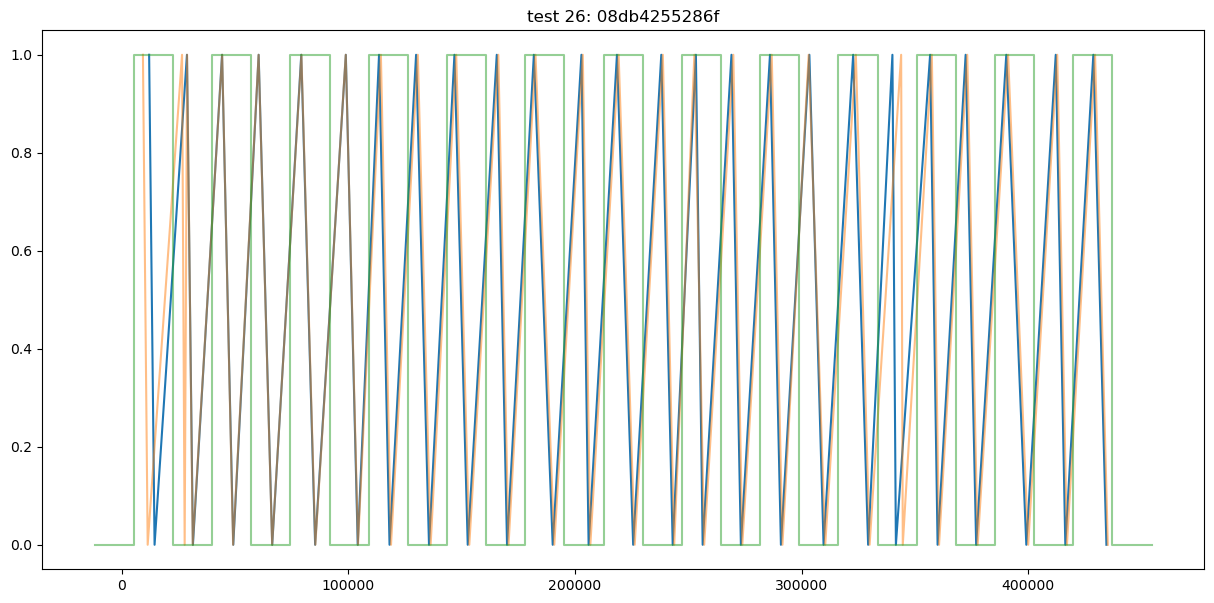

In [123]:
import visual
import matplotlib.pyplot as plt
sids = test_sids[:1]
n = len(sids)
plt.subplots(nrows=n, figsize=(15,7*n))
for i, sid in enumerate(sids):
    plt.subplot(n,1,i+1)
    
    # df = dataloader2.load_sid(f"data/sids/{sid}.parquet")
    data = events[events['series_id']==sid]
    plt.plot(data.step, data.event=='onset')
    # df = preds_df.loc[preds_df['series_id']==sid]
    plt.plot(df.step, df.event=='onset', alpha=0.5)
    st, sl = [],[]
    lim0, lim1 = plt.xlim()
    day = 24*60*12
    print(lim0)
    for i, step in enumerate(range(int(lim0), int(lim1-day), day)):
        st.extend([step, step+day])
        sl.extend([i%2]*2)
    plt.plot(st, sl, alpha=0.5)
    plt.title(f'test {i}: {sid}')


# plt.suptitle(f"Score: {score}")
# plt.tight_layout()



In [122]:
# def drop_intervals(table, interval):
interval = 30*12
table = df
onsets = table.loc[table['event']=='onset']
wakeups = table.loc[table['event']=='wakeup']
onsets.shape, wakeups.shape
drop = set()
# on = onsets.step[0]
for ts_on,ts_wak,i,j in zip(onsets.step[1:], wakeups.step[:-1], onsets.index[1:], wakeups.index[:-1],):
    if ts_on - ts_wak < interval:
        drop.add(i)
        drop.add(j)
table = table.drop(drop)
onsets = table.loc[table['event']=='onset']
wakeups = table.loc[table['event']=='wakeup']
keep = {}
for ts_on,ts_wak,i,j in zip(onsets.timestamp, wakeups.timestamp, onsets.index, wakeups.index):
    night = ts_wak.date()
    if ts_wak.hour < 6:
        night -= pd.Timedelta(1, 'day')
    delta = ts_wak - ts_on
    pi, pj = keep.setdefault(night, (i,j))
    p_delta = onsets.timestamp[pi] - wakeups.timestamp[pj]
    if delta > p_delta:
        keep[night] = (i, j)
k = set()
for i,j in keep.values():
    k.add(i)
    k.add(j)
drop = [i for i in table.index if i not in k]
table = table.drop(drop)
df = table